<h1 align="center">Volume 4: Inverted Pendulum.</h1>

    Caelan osman
    March 16, 2022

In [1]:
import numpy as np
from scipy import optimize
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are

# Problem 1

Write a function that returns the matrices A, B, Q, and R given above. Let
g = 9.8 m/s
2
.

In [2]:
def linearized_init(M, m, l, q1, q2, q3, q4, r, g=9.8):
      '''
      Parameters:
      ----------
      M, m: floats
            masses of the rickshaw and the present
      l: float
            length of the rod
      q1, q2, q3, q4, r: floats
            relative weights of the position and velocity of the rickshaw, the
            angular displacement theta and the change in theta, and the control


      Return
      -------
      A : ndarray of shape (4,4)
      B : ndarray of shape (4,1)
      Q : ndarray of shape (4,4)
      R : ndarray of shape (1,1)
      '''

      A = np.array([[0, 1, 0, 0], 
                    [0, 0, m*g/M, 0], 
                    [0, 0, 0, 1], 
                    [0, 0, g*(M +m)/(M*l), 0]])

      B = np.array([[0], 
                   [1/M], 
                   [0], 
                   [1/(M*l)]])

      Q = np.array([[q1, 0, 0, 0], 
                    [0, q2, 0, 0], 
                    [0, 0, q3, 0], 
                    [0, 0, 0, q4]])

      R = np.array([[r]])
 
      return A, B, Q, R

# Problem 2

Write the following function to find the matrix P. Use scipy.optimize.root.
Since root takes in a vector and not a matrix, you will have to reshape the matrix P before
passing it in and after getting your result, using np.reshape(16) and np.reshape((4,4)).

In [3]:
def find_P(A, B, Q, R, guess = np.ones(16)):
    '''
    Parameters:
    ----------
    A, B, Q : ndarrays of shape (4,4)
    R : ndarray of shape (1,1)
    
    Returns
    -------
    P : the matrix solution of the Riccati equation
    '''
    def F(p):
        # reshape input
        P = p.reshape((4, 4))
        # compute the result
        result = P@A + A.T@P + Q - P@B@B.T@P / R
        # return and flatten result
        return result.flatten()

    # solve
    sol = optimize.root(F, guess)
    P = sol.x
    # reshape and return
    return P.reshape(4, 4)

In [4]:
def e_vals():
    # set constants
    M, m = 23., 5.
    l = 4.
    q1, q2, q3, q4 = 1., 1., 1., 1.
    r = 10.
    # intialize
    A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r)
    # find P
    P = find_P(A, B, Q, R)
    # create matrix
    Mat = A - (B/R)@B.T@P
    # get eigenvalues
    e_vals, _ = np.linalg.eig(Mat)
    print('egenvalues: ', e_vals, sep='\n')

    return

e_vals()

egenvalues: 
[-1.72875212+0.j         -0.07538846+0.07490226j -0.07538846-0.07490226j
  1.72530814+0.j        ]


As we can see, 1 of the eigen values is positive and the remaining three all have negative real part. 
This means the origin is not an asymptotically stable solution. It is stable along the eigenspaces corresponding to $\lambda_2$ and $\lambda_3$ and asymptotically stable along $\lambda_1$ but unstable along the eignespace corresponding to $\lambda_4$.

 # Problem 3
 
Write the following function that implements the LQR solution described earlier.
For the IVP solver, you can use your own or you may use the function odeint from scipy.
integrate.

In [5]:
def rickshaw(tv, X0, A, B, Q, R, P, method='ivp'):
    '''
    Parameters:
    ----------
    tv : ndarray of time values, with shape (n+1,)
    X0 : Initial conditions on state variables
    A, Q: ndarrays of shape (4,4)
    B : ndarray of shape (4,1)
    R : ndarray of shape (1,1)
    P : ndarray of shape (4,4)
    Returns
    -------
    Z : ndarray of shape (n+1,4), the state vector at each time
    U : ndarray of shape (n+1,), the control values
    '''
    # defines the ode to solve for the state
    def ivp(t,  y):
        z = (A - (B/R)@B.T@P)@y
        return z 

    def ode(y,  t):
        z = (A - (B/R)@B.T@P)@y
        return z 

    # pick a method
    if method == 'ivp':
        sol = solve_ivp(ivp, [tv[0], tv[-1]], X0, dense_output=True).sol(tv)
        u = np.squeeze(((-B.T/R)@P) @ sol)

    elif method == 'odeint':
        sol = odeint(ode, X0, tv).T
        u = np.squeeze(((-B.T/R)@P)@ sol)

    else:
        raise ValueError("Incorrect method specification")

    return sol, u

# Problem 4

Test the function made in Problem (3). Find the matrix P using the scipy.optimize.root method with tf=6 as well as the solve_continuous_are
method with tf=60. Plot the solutions z˜ and u˜. Compare your results as shown in Figure
21.3.

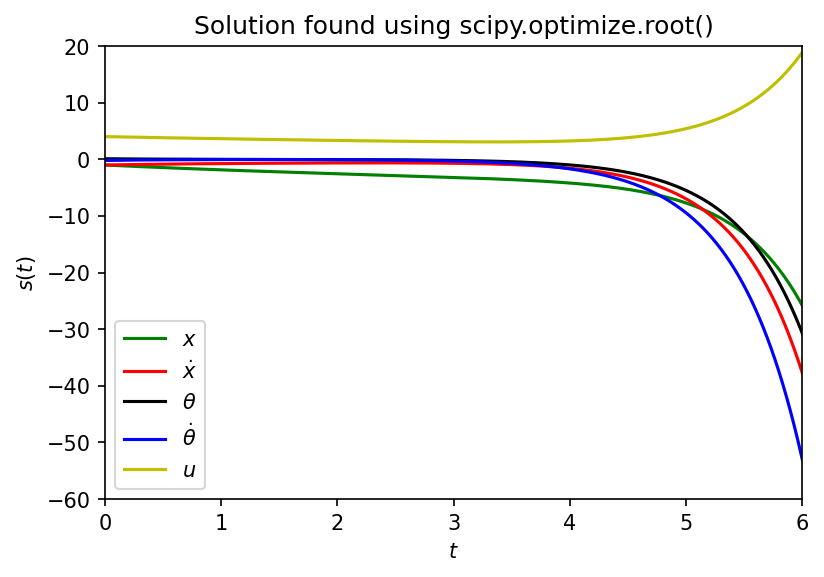

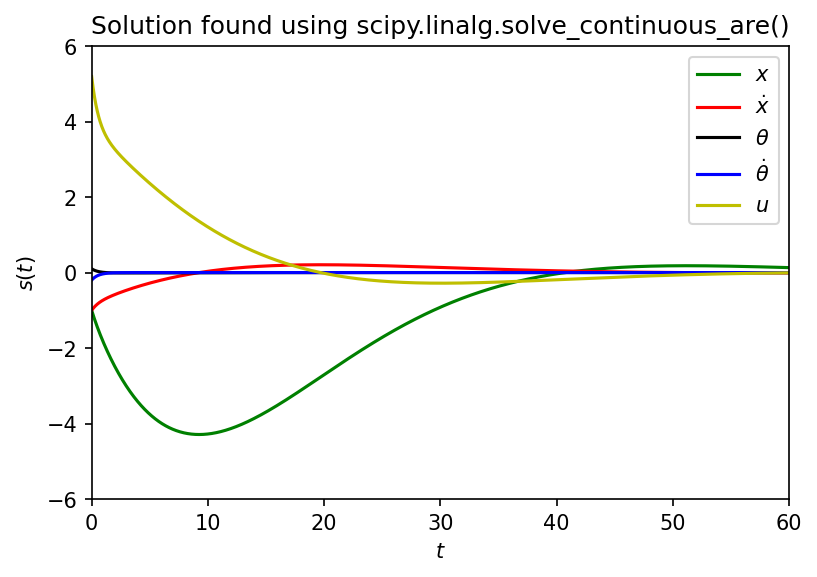

In [6]:
def problem4():
    # set constants
    M, m = 23., 5.
    l = 4.
    q1, q2, q3, q4 = 1., 1., 1., 1.
    r = 10.
    X0 = np.array([-1, -1, .1, -.2])
    A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r)

    # find p using scipy.optimize.root()
    P = find_P(A, B, Q, R)

    # solve the corresponding problem
    tf = 6
    tv = np.linspace(0, tf, 2000)
    sol, u = rickshaw(tv, X0, A, B, Q, R, P, method='ivp')

    # plot the solution
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.plot(tv, sol[0], 'g-', label=r'$x$')
    ax.plot(tv, sol[1], 'r-', label=r'$\dot{x}$')
    ax.plot(tv, sol[2], 'k-', label=r'$\theta$')
    ax.plot(tv, sol[3], 'b-', label=r'$\dot{\theta}$')
    ax.plot(tv, u, 'y-', label=r'$u$')
    ax.legend(loc='best')
    ax.set_xlim([0, 6])
    ax.set_ylim([-60, 20])
    ax.set_xticks(np.arange(0, 7))
    ax.set_yticks(np.arange(-60, 30, 10))
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$s(t)$')
    ax.set_title('Solution found using scipy.optimize.root()')
    plt.show()

    # solve for tf = 60 and using scipy
    tf = 60
    P = solve_continuous_are(A, B, Q, R)
    tv = np.linspace(0, tf, 2000)
    sol, u = rickshaw(tv, X0, A, B, Q, R, P, method='ivp')

    # plot the new solution
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.plot(tv, sol[0], 'g-', label=r'$x$')
    ax.plot(tv, sol[1], 'r-', label=r'$\dot{x}$')
    ax.plot(tv, sol[2], 'k-', label=r'$\theta$')
    ax.plot(tv, sol[3], 'b-', label=r'$\dot{\theta}$')
    ax.plot(tv, u, 'y-', label=r'$u$')
    ax.legend(loc='best')
    ax.set_xlim([0, 60])
    ax.set_ylim([-6, 6])
    ax.set_xticks(np.arange(0, 70, 10))
    ax.set_yticks(np.arange(-6, 8, 2))
    ax.set_title('Solution found using scipy.linalg.solve_continuous_are()')
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$s(t)$')
    plt.show()

    return

problem4()